# Exact quantum dynamics with the new (PyTorch) TD-SE (SOFT) solver

## Table of Content <a name="TOC"></a>

1. [General setups](#1)
2. [Model Hamiltonians](#2)
3. [Initial wavefunctions](#3)
4. [Running calculations](#4)
5. [Plotting the results](#5)

    5.1. [Plotting the probability density profile (in reciprocal space) of 1D system](#5.1)
    
    5.2. [Plotting the contour plots of the probability density for 2D system](#5.2)
    
    5.3. [Plot the potential](#5.3)
    
    5.4. [Plot the energies](#5.4)

    5.5. [Plot the transmission probabilities](#5.5)
    

### A. Learning objectives

- to define the model Hamiltonian suitable for the new TDSE solver
- to setup and execute a quantum dynamics calculation for 1D and 2D Hamiltonians using new exact solver written with PyTorch
- to plot the snapshots of the wavefunction probability density
- to compute transmission probability in scattering models
- to save the results of the new TDSE solver calculations and using them to plot the figures


### B. Use cases

- [Potential energy surfaces with PyTorch](#2)
- [Plot the PES profiles with multidimensional model Hamiltonians](#2)
- [Numerically exact solution of the TD-SE](#4)
- [Numerically exact solution of the TD-SE using PyTorch](#4)
- [Snapshots of the dynamics in 1D](#5.1) 
- [Plotting evolution of properties from exact dynamics calculations](#5.5) | [also here](#5.4)
- [`Save and load the PyTorch tensors to/from file`](#5.1)


### C. Functions

None

### D. Classes and class members

- `libra_py`
  - `dynamics`
    - `exact_torch`
      - `compute`
        - [`Martens_model`](#2) | [`also here`](#4)
        - [`gaussian_wavepacket`](#3)
        - [`exact_tdse_solver`](#4)


## 1. General setups 
<a name="1"></a>[Back to TOC](#TOC)

For producing animated gifs, we need one extra library **imageio**:

    conda install -c conda-forge imageio
    

In [1]:
import torch
import torch.fft
import libra_py.dynamics.exact_torch.compute as compute
import matplotlib.pyplot as plt

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=24)      # fontsize of the x and y labels
plt.rc('legend', fontsize=24)     # legend fontsize
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

## 2. Model Hamiltonians
<a name="2"></a>[Back to TOC](#TOC)

Functions defining the model Hamiltonian (in diabatic representation) suitable for the new solver should be written like this:

<a name="models-1"></a><a name="models-1"></a>

In [2]:
def sech(x):
  return 1 / torch.cosh(x)

def Martens_model(q, params):
    """
    q - Tensor(ndof)

    Martens_model1 is just this one but with Vc = 0.0
    """
    #params = {"Va": 0.00625, "Vb": 0.0106}
    Va = params.get("Va", 0.00625)
    Vb = params.get("Vb", 0.0106)
    Vc = params.get("Vc", 0.0)
    return Va * (sech(2.0*q[0]))**2 + 0.5 * Vb * (q[1] + Vc * (q[0]**2 - 1.0 ) )**2

# Example: harmonic potential
def harmonic_potential(q, params):  # X shape: (ndim, ...)
    """
    q - Tensor(ndof)
    """
    mass = torch.tensor( params.get("mass", [2000.0]) )
    omega = torch.tensor( params.get("omega", [0.004]) )
    k = torch.sqrt( mass * omega**2 )
    return  0.5 * k * torch.sum(q**2, dim=0)

The first one is already defined in the imported module: `compute.Martens_model`

## 3. Initial wavefunctions
<a name="3"></a>[Back to TOC](#TOC)

One can also define a function that computes the initial wavefunction on a grid

<a name="psi0-1"></a><a name="psi0-1"></a>

In [3]:
def gaussian_wavepacket(q, params):
    """
    q = tensor( [ndof, N_1, N_2, ... N_ndof] )
    
    """
    hbar = 1.0
    ndof = q.shape[0]
    sz = len(q.shape)
    
    mass = torch.tensor(params.get("mass", [2000.0, 2000.0]) )
    omega = torch.tensor(params.get("omega", [0.004, 0.004]) )
    sigma = 1.0 / torch.sqrt( 2.0 * mass * omega )
    q0 = torch.tensor(params.get("q0", [-1.0, 0.0]) )
    p0 = torch.tensor(params.get("p0", [3.0, 0.0]) )

    # Reshape q, p, sigma to be compatible in shape with q
    sigma = sigma.view(ndof, *[1]*(sz - 1) )
    q0 = q0.view(ndof, *[1]*(sz - 1) )
    p0 = p0.view(ndof, *[1]*(sz - 1) )

    # Do the calculations:        
    phase = 1j * torch.sum(p0 * q, dim=0, keepdim=False) / hbar
    envelope = torch.exp(-torch.sum( 0.25*(q - q0)**2 / sigma**2 , dim=0, keepdim=False) )  # because it is wavefunction
    norm = torch.prod(1.0 / ( (sigma * (2 * torch.pi)**0.5 )**0.5 ) , dim=0, keepdim=False)
    
    return (norm * envelope * torch.exp(phase))  # this also reduces the first dimension of q

Such a function is also defined in the imported module: `compute.gaussian_wavepacket`

This definition works for any dimensionality of the wavefunction, but the inputs should be consistent with the shape of the corresponding coordinate inputs:

In [4]:
a = torch.rand([1,3])
print(a)
g = gaussian_wavepacket(a, {"mass":[1.0], "omega":[0.01], "q0":[0.0], "p0":[0.0]})
print(g)
print(g.shape)

a = torch.rand([2, 3, 3])
print(a)
g = gaussian_wavepacket(a, {"mass":[1.0, 1.0], "omega":[0.01, 0.01], "q0":[0.0, 0.0], "p0":[0.0, 0.0]})
print(g)
print(g.shape)

tensor([[0.8332, 0.0921, 0.6868]])
tensor([0.2367+0.j, 0.2375+0.j, 0.2370+0.j])
torch.Size([3])
tensor([[[0.3598, 0.5583, 0.8160],
         [0.8632, 0.8831, 0.6687],
         [0.8229, 0.0825, 0.5584]],

        [[0.2475, 0.0053, 0.2860],
         [0.1318, 0.2023, 0.3875],
         [0.8829, 0.6727, 0.3567]]])
tensor([[0.0564+0.j, 0.0563+0.j, 0.0562+0.j],
        [0.0562+0.j, 0.0562+0.j, 0.0563+0.j],
        [0.0560+0.j, 0.0563+0.j, 0.0563+0.j]])
torch.Size([3, 3])


## 4. Running calculations
<a name="4"></a>[Back to TOC](#TOC)

To run calculations:

- just uncomment the line calling the `compute.exact_tdse_solver` function with the corresponding set of parameters (dictinary).
- this constructs the solver object
- run the calculations with `solver.run()`
- collect the results in the file that will be created at the end

Below, there are examples of 1D and 2D simulations. The dimensionality is determined by the `grid_size` parameter. Other list-like parameters should be consistent with it.

Here is what the parameters mean:

* `grid_size` - how many grid points should be used along each dimensions; should be an integer power of 2, e.g. 4, 8, 16, etc.
  
* `prefix` - the name of the file to which the state of the solver (and the results) will be stored

* `q_min` - the lower position end for each axis

* `q_max` - the upper position end for each axis

* `dt` - the integration time-step (a.u.)

* `nsteps` - for how many steps integrate the TD-SE

* `save_every_n_steps` - how many steps of integration to conduct before saving the variables to the memory and eventually to the file.
            Keep in mind, since we are saving the multi-dimensional wavefunctions, which may be quite large. It is important to choose this
            parameter carefully, otherwise one may end up with the files of many Gigabiytes, if not more.

* `mass` - the mass for every degree of fredom

* `potential_fn` - the pointer to the Python function that implements diabatic Hamiltonian. It should be in certain format - check the
           above section for examples

* `potential_fn_params` - the parameters of the called Hamiltonian function

* `psi0_fn` - the pointer to the Python function that implements the initial wavefunction construction. It should also be in a certain
          format. See the example given above.

* `psi0_fn_params` - the parameters of the function that computes the initial wavefunction. The parameters may be function-specific. For the
          Gaussian wavepacket initialization, they arE:

  - `mass` - the mass used in computing the width parameter of the Gaussian $\omega = \sqrt {2 m \omega}$
  - `omega` - the frequency used in computing the width parameter of the Gaussian $\omega = \sqrt {2 m \omega}$
  - `q0` - the position of the envelope center
  - `p0` - the momentum of the wavepacket


In [5]:
params_1D = { "grid_size":[256], "prefix":"HO-1D-exact",
              "q_min":[-15.0], "q_max":[15.0],
              "dt": 1.0,  "nsteps":100, "save_every_n_steps":10,
              "mass": [2000.0],
              "potential_fn":harmonic_potential, "potential_fn_params":{},
              "psi0_fn": compute.gaussian_wavepacket, 
              "psi0_fn_params":{ "mass": [2000.0], "omega":[0.004], "q0":[0.0], "p0":[0.0] }
            }

params_2D = { "grid_size":[256, 128], "prefix":"MartensI-case1-exact",
              "q_min":[-10.0, -5.0], "q_max":[20.0, 5.0],
              "dt": 10.0,  "nsteps":123, "save_every_n_steps":10,
              "mass": [2000.0, 2000.0], "omega":[0.004, 0.004],
              "potential_fn":Martens_model, "potential_fn_params":{},
              "psi0_fn": compute.gaussian_wavepacket, 
              "psi0_fn_params":{ "mass": [2000.0, 2000.0], "omega":[0.004, 0.004], "q0":[-1.0, 0.0], "p0":[3.0, 0.0] }
            }

params_2D_2 = { "grid_size":[128, 128], "prefix":"HO-2D-exact",
              "q_min":[-10.0, -10.0], "q_max":[10.0, 10.0],
              "dt": 1.0,  "nsteps":100, "save_every_n_steps":10,
              "mass": [2000.0, 2000.0], "omega":[0.004, 0.004],
              "potential_fn":harmonic_potential, "potential_fn_params":{},
              "psi0_fn": compute.gaussian_wavepacket, 
              "psi0_fn_params":{ "mass": [2000.0, 2000.0], "omega":[0.004, 0.004], "q0":[-1.0, 0.25], "p0":[0.0, 0.0] }
            }

solver = compute.exact_tdse_solver(params_1D)
#solver = compute.exact_tdse_solver(params_2D)
#solver = compute.exact_tdse_solver(params_2D_2)
solver.solve()

Initializing grids
grid_size =  tensor([256])
Q grid =  torch.Size([1, 256])
dq =  tensor([0.1176])
K grid =  torch.Size([1, 256])
dk =  tensor([0.2086])
dV =  tensor(0.1176)
dVk =  tensor(0.2086)
Step 0: KE = 0.0010, PE = 0.0056, Total = 0.0066, Norm = 1.0000
Step 10: KE = 0.0010, PE = 0.0055, Total = 0.0066, Norm = 1.0000
Step 20: KE = 0.0012, PE = 0.0054, Total = 0.0066, Norm = 1.0000
Step 30: KE = 0.0014, PE = 0.0052, Total = 0.0066, Norm = 1.0000
Step 40: KE = 0.0016, PE = 0.0050, Total = 0.0066, Norm = 1.0000
Step 50: KE = 0.0020, PE = 0.0046, Total = 0.0066, Norm = 1.0000
Step 60: KE = 0.0023, PE = 0.0043, Total = 0.0066, Norm = 1.0000
Step 70: KE = 0.0027, PE = 0.0039, Total = 0.0066, Norm = 1.0000
Step 80: KE = 0.0032, PE = 0.0034, Total = 0.0066, Norm = 1.0000
Step 90: KE = 0.0036, PE = 0.0030, Total = 0.0066, Norm = 1.0000


## 5. Plotting the results
<a name="5"></a>[Back to TOC](#TOC)

This tutorial comes with pre-computed results stored in the files in the `references` folder. 

To access them, we need to load the objects via `torch.load("name-of-the-file")`. The resulting object will have the 
following properties:

* `grid_size`, `q_min`, `q_max`, `dt`, `nsteps`, `save_every_n_steps`, `mass` - see above
* `ndim` - the dimensionality of the problem
* `psi` - current wavefunction on the grid in position representation
* `psi_k` - current wavefunction on the grid in momentum representation
* `prob_density` - current probability density on the grid in the position representation
* `psi_all` - all wavefunction (stored every `save_every_n_steps` steps)
* `time` - the time values for the saved wavefunction snapshots
* `Q` - coordinate grid
* `K` - momentum grid
* `dq` - coordinate grid spacings
* `dk` - momentum grid spacings
* `dV` - volume element in the coordinate space
* `dVk` - volume element in the momentum space
* `kinetic_energy` - kinetic energy stored every `save_every_n_steps` steps
* `potential_energy` - potential energy stored every `save_every_n_steps` steps
* `total_energy` - total energy stored every `save_every_n_steps` steps
* `population_right` - the population for positive values of the first DOF
* `norm` - current norm
* `V` - diabatic Hamiltonian (potential) on the grid
* `T` - kinetic energy on the grid                      


These properties can be accessed directly from the `solver` object or from the dictionary after e.g.:

```
f = torch.load("references/MartensI-case1-exact.pt")
```

### 5.1. Plotting the probability density profile (in reciprocal space) of 1D system
<a name="5.1"></a>[Back to TOC](#TOC)

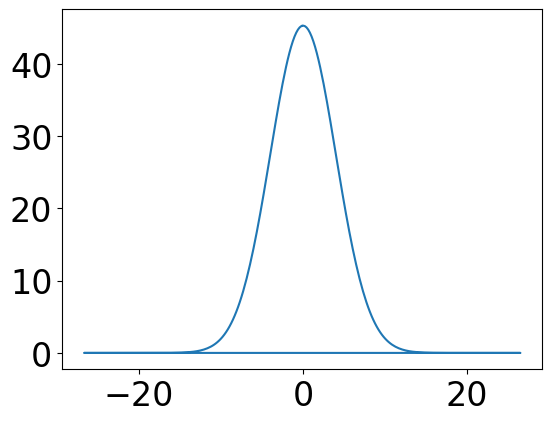

tensor(1.0000)


In [6]:
# for the current (last) state
f = torch.load("references/HO-1D-exact.pt")
psi = f["psi_k"] 
rho = torch.abs( psi )**2 
plt.plot(f["K"][0], rho)
plt.show()

# Also, lets compute the wavefunction norm in the momentum spaces:
nrm = torch.sum(rho) * (f["dq"]/f["grid_size"]).prod()  
print(nrm)

### 5.2. Plotting the contour plots of the probability density for 2D system
<a name="5.2"></a>[Back to TOC](#TOC)

Now, let's do it for 2D system and in real (coordinate) space. We also will plot several snapshots to see the dynamics:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


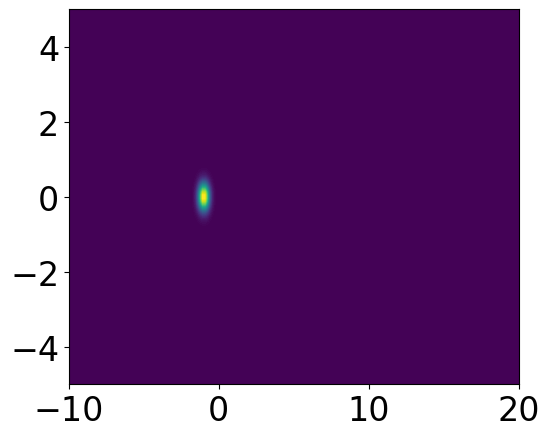

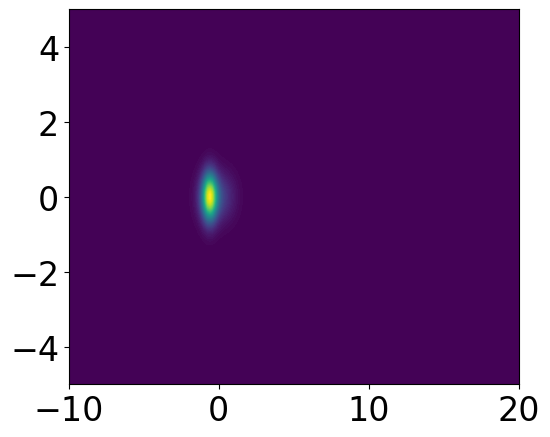

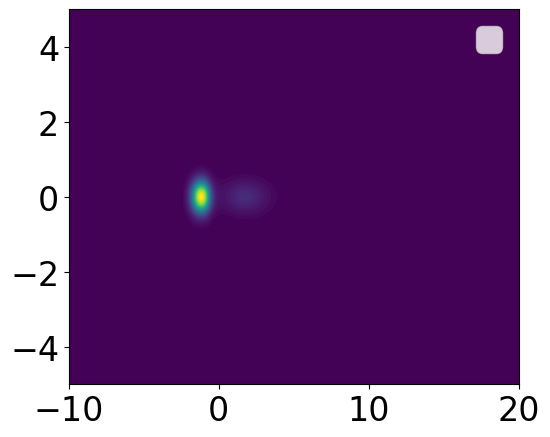

In [7]:
f = torch.load("references/MartensI-case1-exact.pt")
for num, i in enumerate([0, 60, 120]): 
    n = f["save_every_n_steps"]
    Q = f["Q"]
    psi = f["psi_all"][int(i/n)]
    rho = (torch.abs( psi ) )**2 
    plt.figure(num=num, figsize=(6, 5))
    plt.contourf(f["Q"][0], f["Q"][1], rho, levels=100, cmap="viridis")
plt.legend()
plt.show()

### 5.3. Plot the potential
<a name="5.3"></a>[Back to TOC](#TOC)

Since it is already precomputed on the grid, we can easily plot is:

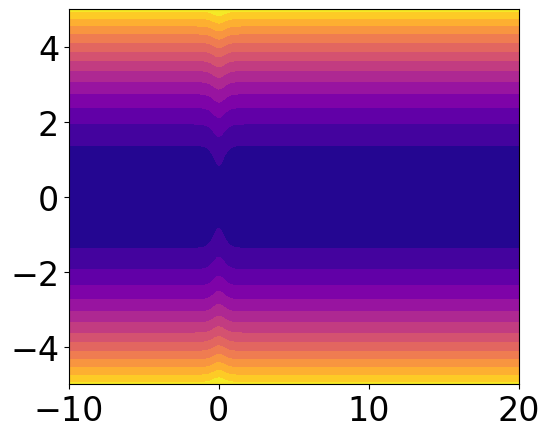

In [8]:
f = torch.load("references/MartensI-case1-exact.pt")
Q = f["Q"]
V = f["V"]
plt.figure(num=3, figsize=(6, 5))
plt.contourf(Q[0], Q[1], V, levels=15, cmap="plasma")
#plt.legend()
plt.show()

### 5.4. Plot the energies
<a name="5.4"></a>[Back to TOC](#TOC)

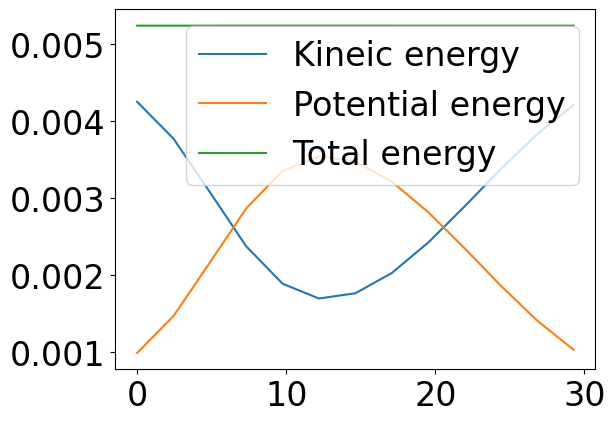

In [9]:
f = torch.load("references/MartensI-case1-exact.pt")
t = torch.tensor(f["time"])/41.0  # to convert to fs
ekin = f["kinetic_energy"]
epot = f["potential_energy"]
etot = f["total_energy"]

plt.plot(t, ekin, label="Kineic energy")
plt.plot(t, epot, label="Potential energy")
plt.plot(t, etot, label="Total energy")
plt.legend()
plt.show()

### 5.5. Plot the transmission probabilities
<a name="5.5"></a>[Back to TOC](#TOC)

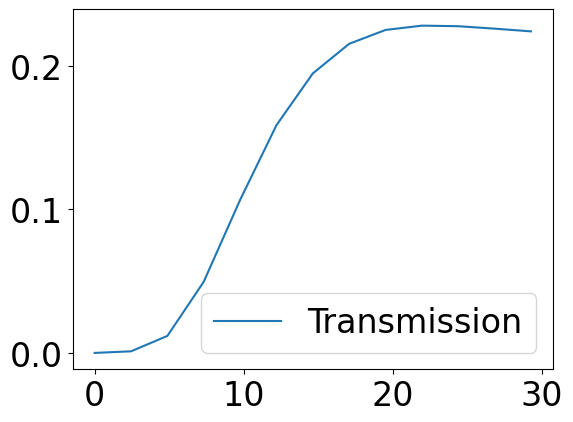

In [10]:
f = torch.load("references/MartensI-case1-exact.pt")
t = torch.tensor(f["time"])/41.0  # to fs.
P = f["population_right"]

plt.plot(t, P, label="Transmission")
plt.legend()
plt.show()